In [1]:
# imports 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.canny_edge import canny_edge
import cv2
import numpy as np
from PIL import Image

LOW_THRSCH, HIGH_THRSCH = 50, 150


In [2]:
def save_canny(frame: np.ndarray, i_frame: int, path: str):
    """Save canny edge detection of a frame.

    Args:
        frame (np.ndarray): Frame to be processed.
        i_frame (int): Frame number.
        path (str): Path to save the image.
    """
    canny = canny_edge(frame, LOW_THRSCH, HIGH_THRSCH)
    cv2.imwrite(path + f"canny_{i_frame}.png", canny)

    

In [5]:

cap = cv2.VideoCapture('/home/wolf/worqspace/EagleEyez/data/sections.mov')
i_frame = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = np.asanyarray(frame)
    save_canny(frame, i_frame, "/home/wolf/worqspace/EagleEyez/res/canny_full/")
    
    i_frame += 1
    print(i_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


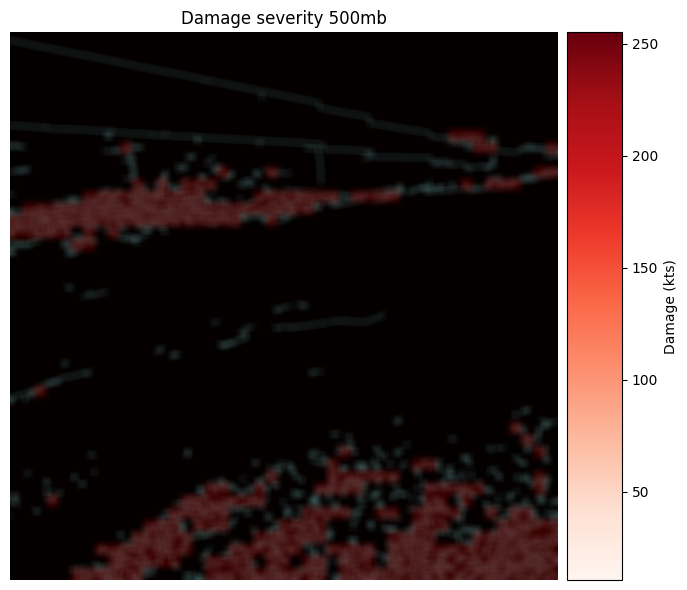

In [25]:

def get_barometer(frame: np.ndarray, i_frame: int):
    """Plots a barometer plot of the damage severity at a given pressure level

    Args:
        frame (np.ndarray): _description_
        i_frame (int): _description_
    """

    p_level = 500

    # convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    # Check if the frame is empty
    if np.sum(frame) == 0:
        return

    canny = canny_edge(frame, LOW_THRSCH, HIGH_THRSCH)

    # crop am rectangle 
    canny = canny[100:1000, 100:1000]

    Image.fromarray(canny).save('data/barometer/canny_{:03d}.png'.format(i_frame))

    # interpolate ua and va to pressure level
    u_500 = np.sum(canny, axis=0).max()
    v_500 = np.sum(canny, axis=1).max()
    # specify your map boundaries
    lat_min = 5
    lat_max = 25
    lon_min = 115
    lon_max = 138
    # get the lat, lon grid
    # specify your colormap and projection
    cmap = plt.get_cmap('Reds')
    # canny_inversed = cv2.bitwise_not(canny)
    # cmap = cv2.COLORMAP_INFERNO
    # canny = cv2.normalize(canny, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # canny = cv2.applyColorMap(canny, cv2.COLORMAP_INFERNO)
    # canny = cv2.cvtColor(canny, cv2.COLOR_BGR2RGB)
    canny_red = cv2.applyColorMap(canny, cv2.COLORMAP_INFERNO)
    # Overlay a red heatmap based on how much white pixels are in the filter area of 20x20 pixels
    filter_size = 20
    empty_overlay = canny_red.copy()
    for i in range(0, canny.shape[0], filter_size):
        for j in range(0, canny.shape[1], filter_size):
            # get the filter area
            filter_area = canny[i:i+filter_size, j:j+filter_size]
            # count the white pixels
            white_pixels = np.sum(filter_area == 255)
            # if there are more than 50 white pixels, overlay a red heatmap
            if white_pixels > 50:
                empty_overlay[i:i+filter_size, j:j+filter_size, :] = [111, 0, 0]
    # overlay the red heatmap
    # empty_overlay = cv2.cvtColor(empty_overlay, cv2.COLOR_GRAY2BGR)
    canny_red = cv2.addWeighted(canny_red, 0.5, empty_overlay, 0.5, 0)

    # canny_red = cv2.cvtColor(canny_red, cv2.COLOR_BGR2RGB)

    #    Gaussian blur
    canny_red = cv2.GaussianBlur(canny_red, (15, 15), 10, 10)

    # plot
    fig = plt.figure(figsize=(10,6))    
    ax = fig.add_subplot(111)
    ax.imshow(canny_red)
    clines = np.arange(0, 100, 10)
    # ax.contour(canny, levels=clines, colors='black', linewidths=0.5, alpha=0.5)

    mesh_x, mesh_y = np.meshgrid(np.arange(canny.shape[1]), np.arange(canny.shape[0]))
    # ax.quiver(mesh_x, mesh_y, u_500, v_500, scale=100, color='black', alpha=0.5)

    norm = plt.Normalize(np.mean(canny, axis=0).mean(), np.max(canny, axis=0).mean())
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='vertical', pad=0.01, aspect=10)
    cbar.ax.set_ylabel('Damage (kts)')
    # some fancy  grid lines with numpy

    xgrid = np.arange(int(lon_min-10), int(lon_max+10), 5.)
    ygrid = np.arange(int(lat_min-10), int(lat_max+10), 5.)

    # set the gridlines
    xy = np.arange(0, 100, 10)
    grid = np.meshgrid(xy, xy)
    ax.grid( True, which='both', axis='both', linestyle='-', color='r', linewidth=0.5, alpha=0.3)

    # set other plot parameters
    # plt.xlim((lon_min,lon_max))
    # plt.ylim((lat_min, lat_max))
    plt.title('Damage severity 500mb')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('data/barometer/barometer_{:03d}.png'.format(i_frame), bbox_inches='tight', pad_inches=0.1)
    plt.imshow(canny_red)
    # plt.close()


im_path = 'data/png/s1/0156.png'
get_barometer(np.asarray(Image.open(im_path)).copy(), 56)

In [26]:
# Process VIdeo
from tqdm import tqdm


cap = cv2.VideoCapture('/home/wolf/worqspace/EagleEyez/data/sections.mov')
i_frame = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = np.asanyarray(frame)
    try:
        barometer = get_barometer(frame, i_frame)
        print('Frame {} processed'.format(i_frame))
    except:
        print('Frame {} failed'.format(i_frame))
        pass
    
    i_frame += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


Frame 0 processed
Frame 1 processed
Frame 2 processed
Frame 3 processed
Frame 4 processed
Frame 5 processed
Frame 6 processed
Frame 7 processed
Frame 8 processed
Frame 9 processed
Frame 10 processed
Frame 11 processed
Frame 12 processed
Frame 13 processed
Frame 14 processed
Frame 15 processed
Frame 16 processed
Frame 17 processed
Frame 18 processed
Frame 19 processed


/tmp/ipykernel_12123/2400155668.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,6))


Frame 20 processed
Frame 21 processed
Frame 22 processed
Frame 23 processed
Frame 24 processed
Frame 25 processed
Frame 26 processed
Frame 27 processed
Frame 28 processed
Frame 29 processed
Frame 30 processed
Frame 31 processed
Frame 32 processed
Frame 33 processed
Frame 34 processed
Frame 35 processed
Frame 36 processed
Frame 37 processed
Frame 38 processed
Frame 39 processed
Frame 40 processed
Frame 41 processed
Frame 42 processed
Frame 43 processed
Frame 44 processed
Frame 45 processed
Frame 46 processed
Frame 47 processed
Frame 48 processed
Frame 49 processed
Frame 50 processed
Frame 51 processed
Frame 52 processed
Frame 53 processed
Frame 54 processed
Frame 55 processed
Frame 56 processed
Frame 57 processed
Frame 58 processed
Frame 59 processed
Frame 60 processed
Frame 61 processed
Frame 62 processed
Frame 63 processed
Frame 64 processed
Frame 65 processed
Frame 66 processed
Frame 67 processed
Frame 68 processed
Frame 69 processed
Frame 70 processed
Frame 71 processed
Frame 72 pro

: 

: 